<b>What's In Here?</b>

This Notebook is more in-depth into modeling the data.
- First step is to ascertain if all features are needed. Based on the variance of the categorical data from the pandas-profiling report, drop feature Sourcing Channel as it's not carrying much aditional info to the data [shown through change in distribution of target variable while grouping and taking average]
- Encoding Categorical Varaibles: There are mainly three types of categorical variables in this data:
    - Ordinal Variables: (Product Size)
    - Nominal Variables with less number of unique labels: (Manufacturer, ProductType etc.)
    - Nominal Variables with high cardinality: (Area Code)
- Define three different types of encoders to handle these features separately.

<b>Two Different Strategies for modelling</b>

- Without Lag
- With Lag (lagged values of target column)

In the end, I decided to go with the lagged model as it takes into account previous values of sales and also performs better than the other model.

# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from yellowbrick.regressor import prediction_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.set_option("display.max_rows", 100)

# Data Preparation Class

In [6]:
class PreprocessData(BaseEstimator, TransformerMixin):
    """
    Class for Preprocessing the Data
    ...

    Attributes
    ----------
    date_column : str
        name of the date column
    target : str
        name of the target column
    drop_cols : list
        pe-specified list of columns to drop
    add_lags : bool
        the number of legs the animal has (default 4)
    lag_vals : list
        list of lag values to consider
    drop_date : bool
        whether or not to keep the date_column

    Methods
    -------
    groupby_and_process(X)
        Preprocesses dataframe X: datetime preprocessing, add lags, groupby and take average for target variable. Helper Function for transform().
    
    fit(X, y= None)
        It's a preprocessing class so fit_transform() can be used for both training and test data.
    
    transform(X, y= None)
        Calls groupby_and_process(), preprocesses data.
    """
    def __init__(self, date_column, target, drop_cols = None, add_lags = False, lag_vals = [1,2,3], drop_date = False):
        self.date_column = date_column
        self.target = target
        self.drop_cols = drop_cols
        self.add_lags = add_lags
        self.lag_vals = lag_vals
        self.drop_date = drop_date
    
    def groupby_and_process(self, X):
        X = X.copy()
        
        if not isinstance(X[self.date_column].iloc[0], datetime):
            X[self.date_column] = X[self.date_column].apply(lambda x: datetime.strptime("01-" + x, '%d-%b-%y')) 
        X_grouped = X.groupby(by = [x for x in X.columns.tolist() if x != self.target], as_index = False)[self.target].median()
        
        if self.add_lags:
            for lag in self.lag_vals:
                lagged_val = X_grouped.groupby(by = [x for x in X.columns.tolist() if x not in [self.date_column, self.target]],\
                                               as_index = False)[self.target].shift(lag)
                X_grouped[f"{self.target}_lag{lag}"] = lagged_val[self.target].values
            X_grouped.dropna(inplace = True, axis = 'rows')
        
        else:
            X_grouped[self.date_column + "_num"] = X_grouped[self.date_column].dt.month
        if self.drop_cols:
            X_grouped.drop(self.drop_cols, axis = 1, inplace = True)
            
        if self.drop_date:
                X_grouped.drop([self.date_column], axis = 1, inplace = True)
        
        return X_grouped
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_processed = self.groupby_and_process(X)
        return X_processed


class EncodeFeatures(BaseEstimator, TransformerMixin):
    """
    Class for Encoding the Categorical Features
    ...

    Attributes
    ----------
    nominal_cols : list
        list of nominal columns
    ordinal_cols : list
        list of ordinal columns
    cardinal_cols : list
        list of features having high cardinality
    cardinal_max_feats : int
        Number of bits to represent the feature. That many number
        of features will be created.
    ordinal_encoder : category_encoders
        Label Encoder for encoding ordinal columns
    cardinal_encoder : category_encoders
        Hashing Encoder for encoding high cardinal columns


    Methods
    -------
    fit(X, y= None)
        Fits the encoders to the data.
    
    transform(X, y= None)
        transforms the data with the encoders fitted in fit() fn.
        performs Dummy encoding for nominal features.
    """
    def __init__(self, nominal_cols, ordinal_cols, cardinal_cols, cardinal_max_feats = 8):
        self.nominal_cols = nominal_cols
        self.ordinal_cols = ordinal_cols
        self.cardinal_cols = cardinal_cols
        self.cardinal_max_feats = cardinal_max_feats
        self.ordinal_encoder = ce.OrdinalEncoder(cols = self.ordinal_cols)
        self.cardinal_encoder = ce.HashingEncoder(cols= self.cardinal_cols,n_components= self.cardinal_max_feats, hash_method = 'sha256')
        
    def fit(self, X, y = None):
        self.ordinal_encoder.fit(X)
        self.cardinal_encoder.fit(X)
        return self
    
    def transform(self, X, y= None):
        X_encoded = self.ordinal_encoder.transform(X)
        X_encoded = self.cardinal_encoder.transform(X_encoded)
        
        X_encoded = pd.get_dummies(X_encoded, columns = self.nominal_cols, drop_first = True)
        
        return X_encoded
    

class ScaleFeatures(BaseEstimator, TransformerMixin):
    """
    Class for Feature Scaling
    ...
    
    Attributes
    ----------
    features : list
        List of features to scale
    bypass : bool
        if True, the pipeline will be
        executed without feature scaling
        [feature scaling not necessary for XGBoost and RandomForest]
    scaler : sklearn.preprocessing.StandardScaler
        StandardScaler()
        
    Methods
    ----------
    fit(X, y = None)
        fits the scalers to the features supplied as attributes
    transform(X, y = None)
        transforms the features
    """
    def __init__(self, features = None, bypass = False):
        self.features = features
        self.bypass = bypass
        self.scaler = StandardScaler()
        
    def fit(self, X, y = None):
        if self.bypass:
            return self
        X_ = X.copy()
        self.scaler.fit(X_[features])
        return self
    
    def transform(self, X, y = None):
        if self.bypass:
            return X
        X_ = X.copy()
        X_[features] = self.scaler.transform(X_[features])
        return X_

# Custom Regressor

In [7]:
class CustomRegressor(BaseEstimator, RegressorMixin):
    """
    Class for Calling multiple regressors
    ...
    
    Attributes
    ----------
    estimator(None)
        Estimator for performing regression
        
    Methods
    ----------
    fit(X, y = None)
        fits the estimator to the data.
    predict(X, y = None)
        predict on the data X.
    """
    def __init__(self, estimator = None):
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


### Helper Functions

In [8]:
def create_pred_dataframe(actual_data, predicted_data):
    """Function for collating the test data and predcitions into one dataframe
    """
    df = pd.DataFrame()
    df['y_test']  = actual_data
    df['y_pred'] = predicted_data
    df.reset_index(inplace = True, drop = True)
    return df


def print_results(df):
    """Function for printing the performance metrics: MAE, RMSE and R2_Score
    """
    print(f"Mean Absolute Error: {mean_absolute_error(df['y_test'], df['y_pred'])}")
    print(f"Roto Mean Squared Error: {np.sqrt(mean_squared_error(df['y_test'], df['y_pred']))}")
    print(f"R2 Score: {r2_score(df['y_test'], df['y_pred'])}")

    
def plot_distributions(data, column_to_drop):
    """Function for plotting distribution plot before and after 
    dropping a particular feature.
    """
    groupby_index = data.columns.tolist()[:-2]
    dist1 = data.groupby(groupby_index)['Sourcing Cost'].mean().tolist()
    dist2  = data.groupby([x for x in groupby_index if x != column_to_drop])['Sourcing Cost'].median().tolist()
    fig, ax = plt.subplots(figsize = (15, 4))
    l1 = sns.distplot(dist1, hist = False, ax = ax, label = f'Dist W. {column_to_drop}')
    l2 = sns.distplot(dist2, hist = False, ax = ax, label = f'Dist W/O {column_to_drop}')
    ax.set_xlabel("Sourcing Cost")
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution With vs Without {column_to_drop}")
    plt.legend()
    plt.show()

    
def preprocess_test_lag(test_data, training_data):
    """Function for adding previous month lags to the test data.
    This function is only specific to lag based approach.
    """
    month_of_sourcing = datetime.strptime("01-" + test_data['Month of Sourcing'].iloc[0], "%d-%b-%y")
    
    preprocess_kwargs = {'date_column': 'Month of Sourcing',
                        'target': 'Sourcing Cost',
                        'drop_cols': None,
                        'add_lags': False,
                        'drop_date': False}

    prep_obj = PreprocessData(**preprocess_kwargs)
    df_train_processed = prep_obj.fit_transform(training_data)
    df_test_processed = prep_obj.fit_transform(test_data)
    
    X_test_processed = df_test_processed.drop(['Sourcing Cost'], axis = 1)
    y_test_final = df_test_processed['Sourcing Cost']
    X_test_processed['Sourcing Cost'] = 0
    
    df_concat = pd.concat([df_train_processed, X_test_processed], axis = 'rows', ignore_index = True)
    df_concat.drop("Month of Sourcing_num", 1, inplace = True)
    
    preprocess_kwargs['add_lags'] = True
    preprocess_kwargs['drop_cols'] = ['Sourcing Channel']
    
    prep_obj = PreprocessData(**preprocess_kwargs)
    df_processed = prep_obj.fit_transform(df_concat)
    df_processed = df_processed[df_processed['Month of Sourcing'] == month_of_sourcing]
    df_processed.drop(["Sourcing Cost", 'Month of Sourcing'], 1, inplace = True)
    
    return df_processed, y_test_final

In [9]:
random_state = 70

# Loading the Data

In [10]:
data = pd.read_csv("../data/processed/data_outliers_treated_v2.csv")
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


<b>From the Data Analysis Notebook, it was seen that the feature 'Sourcing Channel', 'Manufacturer' and 'Product Type have very low variance, with more than 80% of the observations (76% for Manufacturer) belonging to one particular level of the corresponding Features.</b> <br>
Low Variance Columns may not carry any additional information to the model, so it's better to remove those features!

#### Looking at the Change in Distribution of Sourcing Cost when aggregated in presence and absence of Sourcing Channel

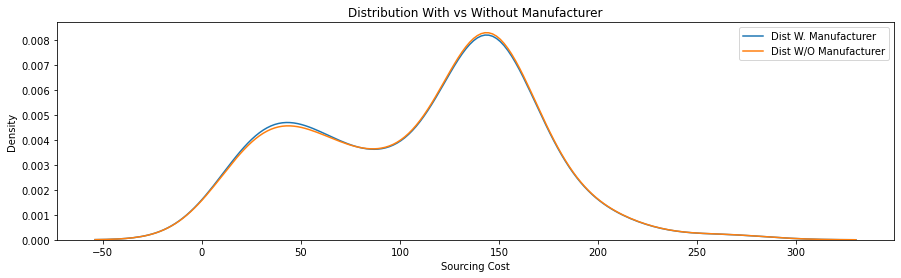

In [6]:
plot_distributions(data, "Manufacturer")

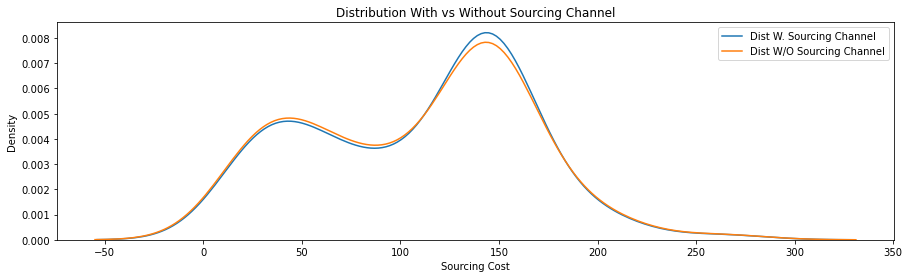

In [7]:
plot_distributions(data, "Sourcing Channel")

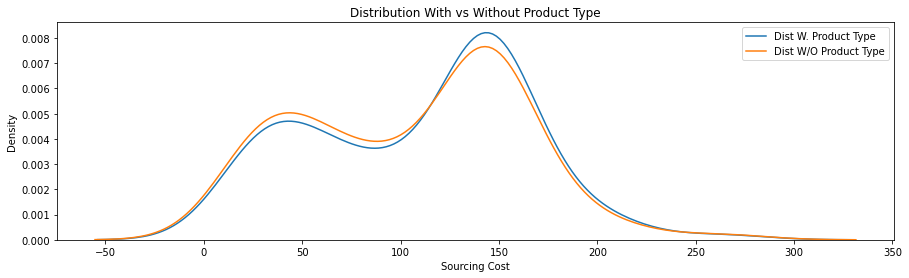

In [8]:
plot_distributions(data, "Product Type")

Product Type has the highest percentage of values at one level (lowest variance), but removing the features affects the distribution of the target variable (average of sourcing cost)
The distribution remain alsmost similar if removing Sourcing Channel and Manufacturer, but since manufacturer has the highest variance between the two, <b>remove Sourcing Channel!</b>


## Encoding Categorical Variables

For column <b>Product Size: </b> Perform Label Encoding as it is an Ordinal Column <br>
For column <b>ProductType, Manufacturer and Product_Type: </b> Perform OHE as these are Nominal and have lesser categories. <br>
For column <b>Area Code: </b> Perform Hash/Binary Encoding

#### Preprocessing

In [11]:
preprocess_kwargs = {'date_column': 'Month of Sourcing',
                   'target': 'Sourcing Cost',
                   'drop_cols': ['Sourcing Channel'],
                    'add_lags': False,
                    'drop_date': True}

prep_obj = PreprocessData(**preprocess_kwargs)
df_processed = prep_obj.fit_transform(data)
df_processed.head()

,ProductType,Manufacturer,Area Code,Product Size,Product Type,Sourcing Cost,Month of Sourcing_num
0,NTM1,X1,A1,Small,Powder,106.43,7
1,NTM1,X1,A1,Small,Powder,103.32,8
2,NTM1,X1,A1,Small,Powder,108.23,9
3,NTM1,X1,A1,Small,Powder,96.08,10
4,NTM1,X1,A1,Small,Powder,110.68,11


#### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop(columns = ['Sourcing Cost']),
                                                   df_processed[['Sourcing Cost']], test_size = 0.3, 
                                                   shuffle = True, random_state = 70)

#### Encoding

In [13]:
encoding_kwargs = {'nominal_cols': ['ProductType', 'Manufacturer', 'Product Type'],
                  'ordinal_cols': ['Product Size'],
                  'cardinal_cols': ['Area Code'],
                  }

encoder = EncodeFeatures(**encoding_kwargs)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [14]:
model = XGBRegressor()
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)


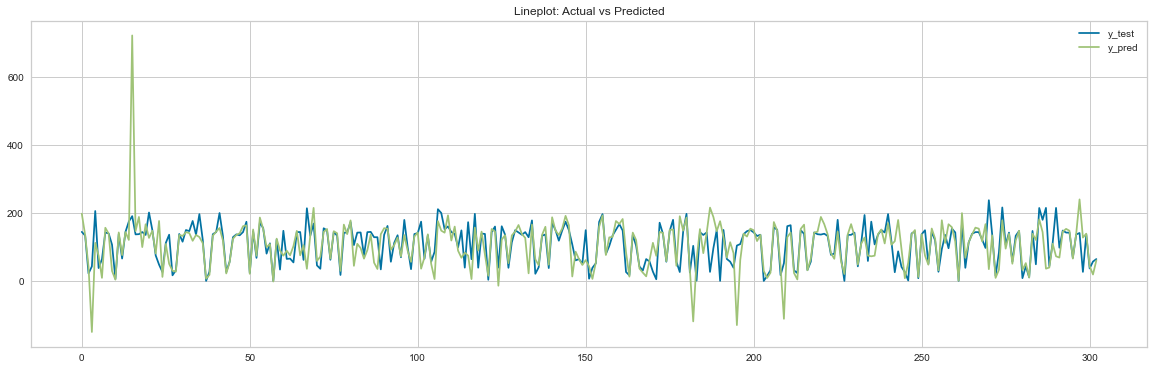

In [15]:
results_df = create_pred_dataframe(y_test['Sourcing Cost'], y_pred)
results_df.plot(figsize = (20, 6))
plt.title("Lineplot: Actual vs Predicted")
plt.show()

In [16]:
print_results(results_df)

Mean Absolute Error: 31.946426358340993
Roto Mean Squared Error: 59.4213821818872
R2 Score: -0.10161916258826476


### Testing Against Given TestData

In [17]:
df_test = pd.read_csv("../data/raw/DS_ML Coding Challenge Dataset - Test Dataset.csv")
df_tst_processed = prep_obj.fit_transform(df_test)
df_tst_processed.head()

,ProductType,Manufacturer,Area Code,Product Size,Product Type,Sourcing Cost,Month of Sourcing_num
0,NTM1,X1,A1,Small,Powder,103.68,6
1,NTM1,X1,A10,Large,Powder,155.75,6
2,NTM1,X1,A10,Large,Powder,143.02,6
3,NTM1,X1,A11,Large,Powder,139.39,6
4,NTM1,X1,A2,Large,Powder,169.42,6


In [18]:
X_tst_processed, y_tst = df_tst_processed.drop("Sourcing Cost", axis = 1), df_tst_processed['Sourcing Cost']
X_tst_encoded = encoder.transform(X_tst_processed)

In [19]:
y_prd = model.predict(X_tst_encoded)

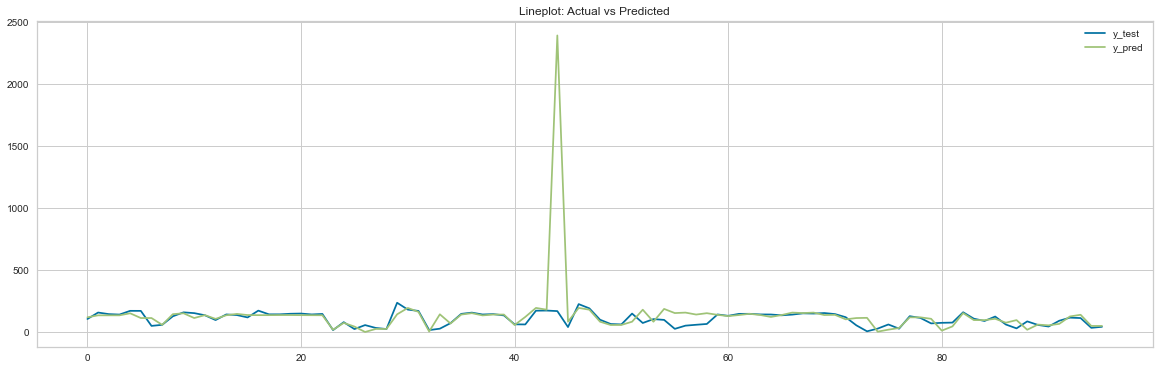

In [20]:
results_df = create_pred_dataframe(y_tst, y_prd)
results_df.plot(figsize = (20, 6))
plt.title("Lineplot: Actual vs Predicted")
plt.show()

In [21]:
print_results(results_df)

Mean Absolute Error: 48.49298744872212
Roto Mean Squared Error: 230.47551303203733
R2 Score: -18.579720853799493


### Lag Based Approach

In [22]:
preprocess_kwargs = {'date_column': 'Month of Sourcing',
                   'target': 'Sourcing Cost',
                   'drop_cols': ['Sourcing Channel'],
                    'add_lags': True,
                    'drop_date': True}

prep_obj2 = PreprocessData(**preprocess_kwargs)
df_lag_processed = prep_obj2.fit_transform(data)
df_lag_processed.head()

,ProductType,Manufacturer,Area Code,Product Size,Product Type,Sourcing Cost,Sourcing Cost_lag1,Sourcing Cost_lag2,Sourcing Cost_lag3
3,NTM1,X1,A1,Small,Powder,96.08,108.23,103.32,106.43
4,NTM1,X1,A1,Small,Powder,110.68,96.08,108.23,103.32
5,NTM1,X1,A1,Small,Powder,112.47,110.68,96.08,108.23
6,NTM1,X1,A1,Small,Powder,111.84,112.47,110.68,96.08
7,NTM1,X1,A1,Small,Powder,113.17,111.84,112.47,110.68


In [23]:
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(df_lag_processed.drop(columns = ['Sourcing Cost']),
                                                   df_lag_processed[['Sourcing Cost']], test_size = 0.3, 
                                                   shuffle = True, random_state = 10)

# Creating Pipeline For Trying out Muliple Algorithms

The following Estimators are used for predicting on the training set <br>
   - XGBoost Regressor <br>
   - RandomForest Regressor <br>
   - Support Vector Regression <br>
   - Ridge Regression <br>

The models are fit with default parameters, the best base model is picked and hyperparameter tuning is performed.

In [24]:
encoding_kwargs = {'nominal_cols': ['ProductType', 'Manufacturer', 'Product Type'],
                  'ordinal_cols': ['Product Size'],
                  'cardinal_cols': ['Area Code'],
                  }

pipeline = Pipeline([
    ('_encoder', EncodeFeatures(**encoding_kwargs)),
    ('_scaler', ScaleFeatures()),
    ('_regressor', CustomRegressor()),
])

In [25]:
features_to_scale = ['Sourcing Cost_lag1', 'Sourcing Cost_lag2', 'Sourcing Cost_lag3']

In [26]:
parameters_ = [
    {'_regressor__estimator': [XGBRegressor()],
    '_scaler__bypass': [True]},
    {'_regressor__estimator': [RandomForestRegressor()],
    '_scaler__bypass': [True]},
    {'_regressor__estimator': [SVR()],
    '_scaler__bypass': [False],
    '_scaler__features': [features_to_scale]},
    {'_regressor__estimator': [Ridge()],
    '_scaler__bypass': [False],
    '_scaler__features': [features_to_scale]},
    
]

gscv_ = GridSearchCV(pipeline, parameters_, cv=5, n_jobs=4, scoring = 'neg_root_mean_squared_error', return_train_score=True, verbose=3)
gscv_.fit(X_train_lag, y_train_lag)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   43.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   43.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('_encoder',
                                        EncodeFeatures(cardinal_cols=['Area '
                                                                      'Code'],
                                                       nominal_cols=['ProductType',
                                                                     'Manufacturer',
                                                                     'Product '
                                                                     'Type'],
                                                       ordinal_cols=['Product '
                                                                     'Size'])),
                                       ('_scaler', ScaleFeatures()),
                                       ('_regressor', CustomRegressor())]),
             n_jobs=4,
             param_grid=[{'_regressor__estimator': [XGBRegressor(base_score=None,
                                   

In [27]:
X_train_lag_encoded = pipeline[0].fit_transform(X_train_lag)
X_test_lag_encoded = pipeline[0].transform(X_test_lag)

## Bayes Search CV for Hyperparameter Optimization

Bayesian optimization over hyper parameters.

In [28]:
parameters = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0.01, 0.5, prior = 'log-uniform'),
    'booster': Categorical(['gbtree', 'dart']) 
}

best_base_model = gscv_.best_params_['_regressor__estimator']
best_model = BayesSearchCV(best_base_model, parameters, cv=5, n_jobs=4, scoring = 'neg_root_mean_squared_error', return_train_score=True, verbose=0)
best_model.fit(X_train_lag_encoded, y_train_lag)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
              n_jobs=4, return_train_score=True,
              scoring='neg_root_mean_squared_error',
              search_spaces={'booster': Categorical(categories=('gbtree', 'dart'), prior=None),
                             'learning_rate': Real(low=0.01, high=0.5, prior='log-un

In [29]:
y_pred_lag = best_model.predict(X_test_lag_encoded)

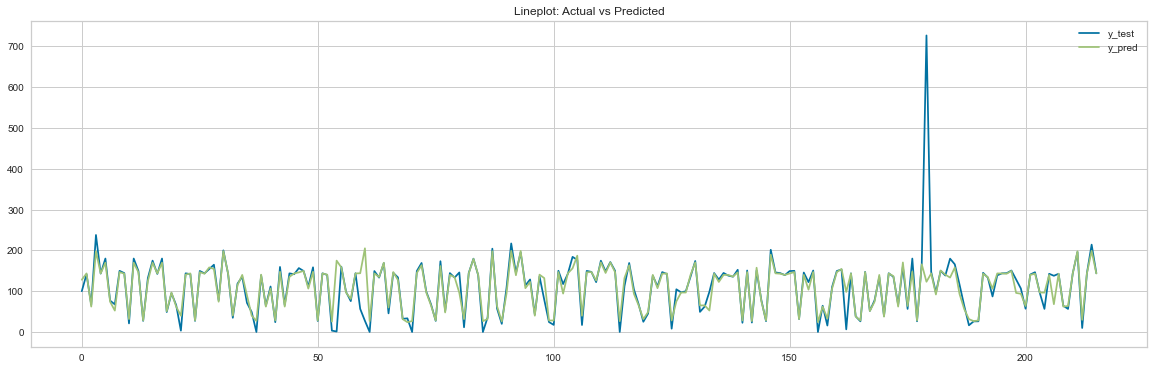

In [30]:
results_df = create_pred_dataframe(y_test_lag['Sourcing Cost'], y_pred_lag)
results_df.plot(figsize = (20, 6))
plt.title("Lineplot: Actual vs Predicted")
plt.show()

In [31]:
print_results(results_df)

Mean Absolute Error: 13.04043168315181
Roto Mean Squared Error: 47.16938790583453
R2 Score: 0.5519354748330638


## Testing Against Given Test Data

In [32]:
df_test = pd.read_csv("../data/raw/DS_ML Coding Challenge Dataset - Test Dataset.csv")

In [33]:
X_test_processed, y_test = preprocess_test_lag(df_test, data)
X_test_processed.head()

,ProductType,Manufacturer,Area Code,Product Size,Product Type,Sourcing Cost_lag1,Sourcing Cost_lag2,Sourcing Cost_lag3
11,NTM1,X1,A1,Small,Powder,114.13,111.73,112.00
23,NTM1,X1,A10,Large,Powder,152.83,149.49,147.64
31,NTM1,X1,A10,Large,Powder,149.46,148.57,146.97
43,NTM1,X1,A11,Large,Powder,142.37,143.97,142.11
55,NTM1,X1,A2,Large,Powder,168.86,160.97,171.28


In [34]:
X_test_encoded = pipeline[0].transform(X_test_processed)

In [35]:
y_pred_final = best_model.predict(X_test_encoded)

#### Getting the Scores

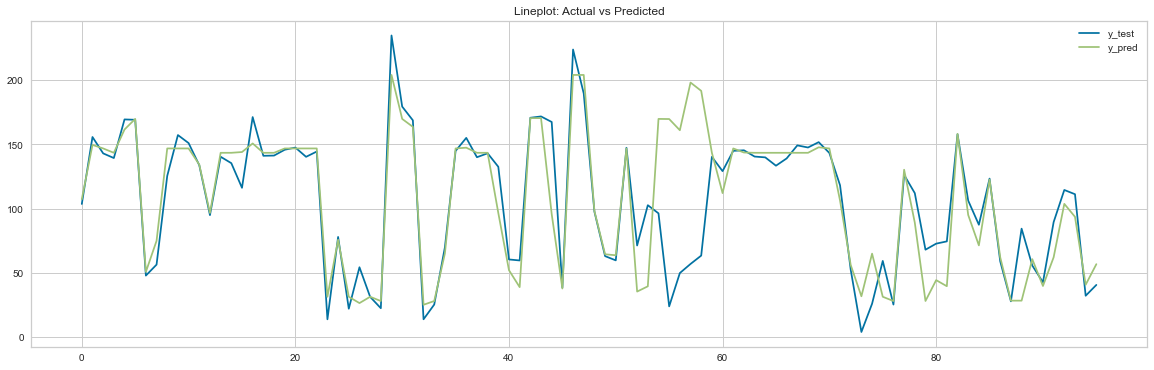

In [36]:
results_df = create_pred_dataframe(y_test, y_pred_final)
results_df.plot(figsize = (20, 6))
plt.title("Lineplot: Actual vs Predicted")
plt.show()

In [37]:
print_results(results_df)

Mean Absolute Error: 17.287691427866616
Roto Mean Squared Error: 33.22039906769051
R2 Score: 0.5932134307829094


### Visualisation via Scatter plot

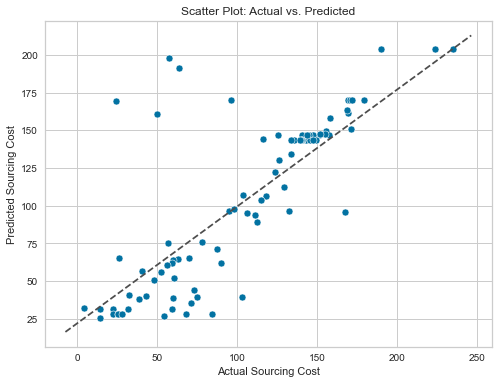

In [38]:
fig, ax = plt.subplots(figsize = (8,6))
sc_plot = sns.scatterplot(x = y_test, y = y_pred_final, ax = ax)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('Actual Sourcing Cost')
plt.ylabel("Predicted Sourcing Cost")
plt.title("Scatter Plot: Actual vs. Predicted")
plt.show()

- The dotted line is the identity line. <br>
- Points closer to the identity line are correctly predicted, [actual is 30 and model predicted 30]
- Points further away from the line have high prediction error.
- Points above the identity line are over-predictions
- Points below the identity line are under-predictions.